# TFT Initial Run

Prep for Colab Load

In [2]:
from darts.models.forecasting.tft_model import TFTModel

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Feb 22 11:00:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install "darts[torch]"
!pip uninstall scikit-learn -y
!pip install --upgrade pip setuptools wheel
!pip install scikit-learn==1.2.2

Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
  Using cached scikit_learn-1.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.6 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import warnings
import logging

# Visualization and numerical processing
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import yfinance as yf

# Statsmodels for time series analysis
from statsmodels.graphics.tsaplots import month_plot, quarter_plot, plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# Sklearn for metrics and parameter grid
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler

# Darts functions
from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.utils.likelihood_models import QuantileRegression
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries

# Disable warnings and logging
warnings.filterwarnings("ignore")
#logging.disable(logging.CRITICAL)

pd.set_option('display.max_rows',60000)
pd.set_option('display.max_columns',500)
pd.set_option('display.max_colwidth',200)
pd.options.display.float_format = '{:,.4f}'.format

If you are using a probabilistic model like Temporal Fusion Transformer (TFT) with a likelihood function (e.g., QuantileRegression), the training loss and validation loss might not behave in the same way as in deterministic models.

In [6]:
#stock_data_ = pd.read_csv('/content/drive/MyDrive/projects_fp/dataset_250222_run.csv')
stock_data_ = pd.read_csv('dataset_250222_run.csv')
stock_data_['date'] = pd.to_datetime(stock_data_['date'],utc=False)
stock_data_['date'] = stock_data_['date'].dt.tz_localize(None)
#stock_data_ = stock_data_[stock_data_['ticker_id'].isin(['NVDA','T'])].copy()  #uncheck this

for x in ['ticker_id','sector']: #'dividends'
    stock_data_[x+'_2'] = stock_data_[x].copy()

for x in ['ticker_id', 'sector']:
    stock_data_[x] = pd.factorize(stock_data_[x])[0]

stock_data = stock_data_.copy()

recon_mapper =  {a:b for a,b in set(zip(stock_data['ticker_id'],stock_data['ticker_id_2']))}

In [7]:
recon_mapper

{8: 'AMZN',
 21: 'JPM',
 33: 'MSFT',
 25: 'UNH',
 24: 'LLY',
 11: 'BKNG',
 29: 'HCA',
 32: 'AAPL',
 6: 'MCD',
 7: 'AZO',
 16: 'OKE',
 1: 'VZ',
 4: 'NFLX',
 2: 'GOOG',
 31: 'TYL',
 10: 'TSLA',
 26: 'BSX',
 14: 'CVX',
 12: 'CTRA',
 20: 'BRK-B',
 35: 'CRM',
 22: 'BAC',
 9: 'HD',
 30: 'IBM',
 17: 'COP',
 19: 'CB',
 27: 'SYK',
 3: 'META',
 34: 'NVDA',
 28: 'ISRG',
 5: 'DIS',
 13: 'XOM',
 0: 'T',
 18: 'PGR',
 23: 'GS',
 15: 'EOG'}

In [8]:
stock_data_['ticker_id_2'].value_counts()

ticker_id_2
T        2171
VZ       2171
BRK-B    2171
JPM      2171
BAC      2171
GS       2171
LLY      2171
UNH      2171
BSX      2171
SYK      2171
ISRG     2171
HCA      2171
IBM      2171
TYL      2171
AAPL     2171
MSFT     2171
NVDA     2171
CB       2171
PGR      2171
COP      2171
AMZN     2171
GOOG     2171
META     2171
NFLX     2171
DIS      2171
MCD      2171
AZO      2171
HD       2171
OKE      2171
TSLA     2171
BKNG     2171
CTRA     2171
XOM      2171
CVX      2171
EOG      2171
CRM      2171
Name: count, dtype: int64

In [9]:
display(stock_data_[stock_data_['ticker_id_2']=='NVDA'][['ticker_id_2','date']].iloc[0])
display(stock_data_[stock_data_['ticker_id_2']=='NVDA'][['ticker_id_2','date']].iloc[-1])

ticker_id_2                   NVDA
date           2016-08-05 00:00:00
Name: 73814, dtype: object

ticker_id_2                   NVDA
date           2024-11-29 00:00:00
Name: 75984, dtype: object

In [10]:
#how many records?
stock_data_[stock_data_['ticker_id_2']=='NVDA'].shape

(2171, 27)

In [11]:
stock_data[stock_data['ticker_id']==0].shape #reshaped to this 2305 rows, 16 features

(2171, 27)

In [12]:
stock_data.columns

Index(['close_pctc', 'volatility_atr_relative_pctc',
       'macd_sig_line_relative_close_pctc', 'macd_relative_close_pctc',
       'beta_close_relative_pctc', 'tr_relative_pctc', 'open_close_pctc',
       'volatility_bbm_relative', 'volatility_bbh_relative', 'momentum_rsi',
       'momentum_rsi_relative_pctc', 'pe_ratio_pctc', 'volatility_bb_width',
       'earnings_date_flag', 'beta_vol_interaction_pctc', 'rolling_beta',
       'beta_close_pctc', 'beta_vol_interaction', 'vix', 'volume_pctc',
       'volatility_bb_width_pctc', 'date', 'ticker_id', 'sector', 'close',
       'ticker_id_2', 'sector_2'],
      dtype='object')

In [13]:
preferred_cols = ['volatility_atr_relative_pctc',
       'macd_sig_line_relative_close_pctc', 'macd_relative_close_pctc',
       'beta_close_relative_pctc', 'tr_relative_pctc', 'open_close_pctc',
       'volatility_bbm_relative', 'volatility_bbh_relative', 'momentum_rsi',
       'momentum_rsi_relative_pctc', 'pe_ratio_pctc', 'volatility_bb_width',
       'beta_vol_interaction_pctc', 'rolling_beta',
       'beta_close_pctc', 'beta_vol_interaction', 'vix', 'volume_pctc',
       'volatility_bb_width_pctc'] #'earnings_date_flag',

In [14]:
len(preferred_cols)

19

In [15]:
stock_data.isnull().sum() #all clear , can loop this

close_pctc                           0
volatility_atr_relative_pctc         0
macd_sig_line_relative_close_pctc    0
macd_relative_close_pctc             0
beta_close_relative_pctc             0
tr_relative_pctc                     0
open_close_pctc                      0
volatility_bbm_relative              0
volatility_bbh_relative              0
momentum_rsi                         0
momentum_rsi_relative_pctc           0
pe_ratio_pctc                        0
volatility_bb_width                  0
earnings_date_flag                   0
beta_vol_interaction_pctc            0
rolling_beta                         0
beta_close_pctc                      0
beta_vol_interaction                 0
vix                                  0
volume_pctc                          0
volatility_bb_width_pctc             0
date                                 0
ticker_id                            0
sector                               0
close                                0
ticker_id_2              

In [16]:
stock_data.head(1) # one more look before u load

,close_pctc,volatility_atr_relative_pctc,macd_sig_line_relative_close_pctc,macd_relative_close_pctc,beta_close_relative_pctc,tr_relative_pctc,open_close_pctc,volatility_bbm_relative,volatility_bbh_relative,momentum_rsi,momentum_rsi_relative_pctc,pe_ratio_pctc,volatility_bb_width,earnings_date_flag,beta_vol_interaction_pctc,rolling_beta,beta_close_pctc,beta_vol_interaction,vix,volume_pctc,volatility_bb_width_pctc,date,ticker_id,sector,close,ticker_id_2,sector_2
0,0.0019,0.0015,0.0023,0.0023,0.0025,-0.0019,0.0007,0.1286,-0.0993,54.8287,0.0504,0.0019,-0.0263,0.0000,0.1420,0.2859,-0.0353,0.9313,11.3900,0.6498,0.0200,2016-08-05,0,0,17.3446,T,Communication Services


## Creating Darts Time Series Objects

Creating Darts TimeSeries objects is essential because they provide a structured way to handle time series data, enabling advanced forecasting, transformation, and analysis. Here’s why you need to create them:

Standardized Data Handling – Darts ensures your time series data is well-structured with a proper time index, avoiding common inconsistencies in timestamps.

Seamless Model Integration – Many forecasting models in Darts, including deep learning models like Temporal Fusion Transformer (TFT), require data in a TimeSeries format for proper training and prediction.

Built-in Preprocessing – Darts makes it easy to handle missing values, normalize data, and apply transformations like differencing or logarithmic scaling.

Multi-variate and Multi-series Support – Unlike raw Pandas DataFrames, TimeSeries objects allow handling multiple correlated time series, making them useful for multi-variable forecasting.

Easy Feature Engineering – You can add covariates (past and future known values) to improve model accuracy.

Advanced Forecasting Capabilities – Darts provides seamless integration with models like ARIMA, Prophet, RNNs, and Transformers, all of which work better with TimeSeries objects.

In summary, creating TimeSeries objects in Darts ensures clean, structured, and optimized data, making it easier to build accurate and efficient time series models.

In [17]:
frequency = 'B'
fill_missing_dates_ = True

# Create TimeSeries objects grouped by ticker
series_ = TimeSeries.from_group_dataframe(
    df=stock_data,
    time_col='date',
    group_cols=['ticker_id'],      # Group by ticker
    value_cols= 'close_pctc',         # Use close price as the target
    freq=frequency,                  # Irregular trading days
    fill_missing_dates=fill_missing_dates_,   # No filling within Darts
    static_cols=['sector']  # Add sector as a static covariate
)

# Create dynamic covariates TimeSeries (volume) grouped by ticker
dynamic_covariates = TimeSeries.from_group_dataframe(
    df=stock_data,
    time_col='date',
    group_cols=['ticker_id'],      # Group by ticker
    value_cols=preferred_cols,   # Dynamic covariate (e.g., volume)'low' 'close_returns_lag_5' 'volume'
    freq=frequency,                   # Business day frequency
    fill_missing_dates=fill_missing_dates_     # Allow filling missing dates
)

# Create the future covariates time series instance from the full DataFrame using group-based columns
future_covariates = TimeSeries.from_group_dataframe(
    df=stock_data,           # Full DataFrame containing both current and future data
    time_col='date',    # Column representing the time dimension
    group_cols=['ticker_id'], # Column(s) representing the group or series identifier(s)
    value_cols=['earnings_date_flag'], # Columns representing the exogenous variables (future covariates)
    freq=frequency,                   # Business day frequency
    fill_missing_dates=fill_missing_dates_           # Frequency of the data
)

## Admin check

In [18]:
# Convert the first TimeSeries object to a Pandas DataFrame
series_df = series_[0].pd_dataframe()

# Display the DataFrame
series_df[series_df['close_pctc'].isnull()].index

DatetimeIndex([], dtype='datetime64[ns]', name='date', freq='B')

In [19]:
# Extract time indices and group labels into a DataFrame
dates_df = pd.DataFrame({
    "ticker_id": [f"Series {i + 1}" for i in range(len(series_))],
    "dates": [ts.time_index for ts in series_]
})

# Expand the time indices into separate rows
dates_df = dates_df.explode("dates").reset_index(drop=True)
#print(dates_df)
print(dates_df.iloc[0])
print(dates_df.iloc[-1])

ticker_id               Series 1
dates        2016-08-05 00:00:00
Name: 0, dtype: object
ticker_id              Series 36
dates        2024-11-29 00:00:00
Name: 78155, dtype: object


### Additional Check
This code snippet is performing a data consistency check by comparing the dates present in two different sources of stock market data:

series_dates – Extracts dates from dates_df where ticker_id == 'Series 1'. This subset represents the dates associated with "Series 1."
original_dates – Extracts unique dates from stock_data["date"], which represents all available dates in the original dataset.
Then, it performs a set difference operation to identify:

missing_in_series → Dates present in original_dates but missing in series_dates.
missing_in_original → Dates present in series_dates but missing in original_dates.

In [20]:
series_dates = dates_df[dates_df['ticker_id']=='Series 1' ]['dates']
original_dates = stock_data["date"].unique()

# Compare
missing_in_series = set(original_dates) - set(series_dates)
missing_in_original = set(series_dates) - set(original_dates)

print(f"Dates in original but not in series_: {missing_in_series}")
print(f"Dates in series_ but not in original: {missing_in_original}")

Dates in original but not in series_: set()
Dates in series_ but not in original: set()


### Why Is This Check Necessary for Re-Iterative Data Cleaning from a TFT Perspective
When using Temporal Fusion Transformer (TFT) for stock market prediction, ensuring data integrity is critical because TFT models rely heavily on temporal patterns and relationships between past, present, and future covariates. This check is necessary for several reasons:

Ensures Time Index Consistency

TFT requires continuous, aligned time series across all variables (historical and future covariates).
If dates are missing in series_dates, it may indicate incomplete or misaligned data, affecting model performance.
Avoids Data Leakage or Loss

If series_dates has extra dates that are not in original_dates, it suggests anomalies or incorrectly joined data, which can introduce bias.
If original_dates has extra dates missing in series_dates, it means data might have been improperly filtered, leading to loss of crucial training information.
Prevents Model Training Errors

TFT models expect a uniform structure in the dataset.
Mismatched timestamps can cause errors during model training, especially when aligning historical and future covariates.
Supports Iterative Data Cleaning

If discrepancies exist, they highlight areas where data cleaning is required before proceeding to modeling.
This iterative process ensures the correct timestamps are retained and missing dates are handled (e.g., through interpolation or imputation).

In [21]:
duplicates = stock_data[stock_data.duplicated(subset=['ticker_id', 'date'], keep=False)]
duplicates #every record is unique

,close_pctc,volatility_atr_relative_pctc,macd_sig_line_relative_close_pctc,macd_relative_close_pctc,beta_close_relative_pctc,tr_relative_pctc,open_close_pctc,volatility_bbm_relative,volatility_bbh_relative,momentum_rsi,momentum_rsi_relative_pctc,pe_ratio_pctc,volatility_bb_width,earnings_date_flag,beta_vol_interaction_pctc,rolling_beta,beta_close_pctc,beta_vol_interaction,vix,volume_pctc,volatility_bb_width_pctc,date,ticker_id,sector,close,ticker_id_2,sector_2


# Split and Scale

#### Splitting Must Come Before Scaling for TFT
Splitting the dataset before scaling is crucial when using Temporal Fusion Transformer (TFT) because it ensures proper generalization, prevents data leakage, and maintains consistent scaling across different datasets.

In [22]:
# Updated split_series function to handle multiple sequences
def split_series_collection(series_collection, train_ratio=0.6, val_ratio=0.2,type_ ='dynamic'):
    train_series = []
    val_series = []
    test_series = []
    combine_series = []

    for series in series_collection:
        # Apply the split logic to each individual sequence
        total_entries = len(series)
        train_size = int(total_entries * train_ratio)
        val_size = int(total_entries * val_ratio)
        test_size = total_entries - train_size - val_size

        train_series.append(series[:train_size])
        val_series.append(series[train_size:train_size + val_size])
        test_series.append(series[train_size + val_size:-40])# for static series only
        combine_series.append(series[:train_size+val_size]) #for forecast purpose

    return (train_series, val_series, test_series, combine_series)

def fit_scalers_on_series(series_collection):
    """
    Fits a separate StandardScaler for each TimeSeries in the collection.

    Args:
        series_collection (list[TimeSeries]): List of TimeSeries to fit scalers.

    Returns:
        list[StandardScaler]: List of fitted scalers, one for each TimeSeries.
    """
    scalers = []
    for ts in series_collection:
        scaler = StandardScaler()
        scaler.fit(ts.values())  # Fit scaler for each series independently
        scalers.append(scaler)
    return (scalers)

def scale_series_with_scalers(series_collection, scalers):
    """
    Scales each TimeSeries using its corresponding StandardScaler.

    Args:
        series_collection (list[TimeSeries]): List of TimeSeries to scale.
        scalers (list[StandardScaler]): List of fitted scalers, one for each TimeSeries.

    Returns:
        list[TimeSeries]: List of scaled TimeSeries.
    """
    scaled_series = []
    for ts, scaler in zip(series_collection, scalers):
        scaled_values = scaler.transform(ts.values())  # Transform each series
        scaled_series.append(TimeSeries.from_times_and_values(ts.time_index, scaled_values))
    return (scaled_series)


# Splitting datasets
train_series, val_series, test_series, combined_series = split_series_collection(series_)
train_dynamic_covariates, val_dynamic_covariates, test_dynamic_covariates, combined_dynamics = split_series_collection(dynamic_covariates)

# Fit scalers on training data
target_scalers = fit_scalers_on_series(train_series)
dynamic_scalers = fit_scalers_on_series(train_dynamic_covariates)

# Scale training, validation, and test sets
train_series_scaled = scale_series_with_scalers(train_series, target_scalers)
val_series_scaled = scale_series_with_scalers(val_series, target_scalers)
test_series_scaled = scale_series_with_scalers(test_series, target_scalers)
combined_series_scaled = scale_series_with_scalers(combined_series, target_scalers)

train_dynamic_covariates_scaled = scale_series_with_scalers(train_dynamic_covariates, dynamic_scalers)
val_dynamic_covariates_scaled = scale_series_with_scalers(val_dynamic_covariates, dynamic_scalers)
test_dynamic_covariates_scaled = scale_series_with_scalers(test_dynamic_covariates, dynamic_scalers)
combined_dynamic_covariates_scaled = scale_series_with_scalers(combined_dynamics, dynamic_scalers)

train_size = len(train_series[0])
val_size = len(val_series[0]) #434
test_size = len(test_series[0]) #435

In [23]:
train_size,val_size,test_size

(1302, 434, 395)

In [24]:
#future_covariates[0].time_index
#test_future_covariates[0].time_index

### Split -Scale Stats

In [25]:
print(train_series[0].time_index[0],train_series[0].time_index[-1])
print('no. of train records:',train_size)

2016-08-05 00:00:00 2021-08-02 00:00:00
no. of train records: 1302


In [26]:
print(val_series[0].time_index[0],val_series[0].time_index[-1])
print('no. of val records:',val_size)

2021-08-03 00:00:00 2023-03-31 00:00:00
no. of val records: 434


In [27]:
print(test_series[0].time_index[0],test_series[0].time_index[-1])
print('no. of test records:',test_size)

2023-04-03 00:00:00 2024-10-04 00:00:00
no. of test records: 395


In [28]:
#assuming no scaling cos 1-0. results may vary after run
def future_split_series(series_collection, train_size, val_size, test_size, output_chunk_length):
    """
    Splits future covariates into train, validation, and test splits,
    extending each split to include the forecast horizon (output_chunk_length).

    Args:
        series_collection (List[TimeSeries]): The collection of future covariate time series.
        train_size (int): Number of time steps in the training split.
        val_size (int): Number of time steps in the validation split.
        test_size (int): Number of time steps in the test split.
        output_chunk_length (int): Forecast horizon to ensure sufficient future covariates.

    Returns:
        Tuple[List[TimeSeries], List[TimeSeries], List[TimeSeries]]:
            - train_future_covariates
            - val_future_covariates
            - test_future_covariates
    """
    train_future_covariates = []
    val_future_covariates = []
    test_future_covariates = []

    for series in series_collection:
        total_length = len(series)

        # Train split
        train_end = train_size
        train_split = series[:train_end + output_chunk_length]  # Extend for forecast horizon
        train_future_covariates.append(train_split)

        # Validation split
        val_start = train_size
        val_end = train_size + val_size
        val_split = series[val_start:val_end + output_chunk_length]  # Extend for forecast horizon
        val_future_covariates.append(val_split)

        # Test split
        test_start = train_size + val_size
        #test_end = train_size + val_size #+ test_size #do not include test size
        test_split = series[test_start:]  # Extend for forecast horizon
        #test_split = series[test_start:test_end + output_chunk_length]
        test_future_covariates.append(test_split)

    return train_future_covariates, val_future_covariates, test_future_covariates

output_chunk_length_for_future = 40  # New Forecast horizon

# Split the future covariates
train_future_covariates, val_future_covariates, test_future_covariates = future_split_series(
    future_covariates, train_size, val_size, test_size, output_chunk_length_for_future
)

In [29]:
print(train_future_covariates[0].time_index[0],train_future_covariates[0].time_index[-1])
print('no. of train future records:',len(train_future_covariates[0]))

2016-08-05 00:00:00 2021-09-27 00:00:00
no. of train future records: 1342


In [30]:
print(val_future_covariates[0].time_index[0],val_future_covariates[0].time_index[-1])
print('no. of val future records:',len(val_future_covariates[0]))

2021-08-03 00:00:00 2023-05-26 00:00:00
no. of val future records: 474


In [31]:
print(test_future_covariates[0].time_index[0],test_future_covariates[0].time_index[-1])
print('no. of val future records:',len(test_future_covariates[0]))

2023-04-03 00:00:00 2024-11-29 00:00:00
no. of val future records: 435


# Main Model Run

In [39]:
from pytorch_lightning.callbacks import Callback
from torch.optim import Adam # Define the Adam optimizer class
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor

from pytorch_lightning.loggers import TensorBoardLogger

import torch
from darts.models.forecasting.tft_model import TFTModel
from darts.utils.likelihood_models import QuantileRegression

In [ ]:
class MetricsLogger(Callback):
    def __init__(self):
        super().__init__()
        self.history = []

    def on_validation_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        self.history.append({
            "epoch": trainer.current_epoch,
            "train_loss": metrics.get("train_loss", None).item() if metrics.get("train_loss", None) else None,
            "val_loss": metrics.get("val_loss", None).item() if metrics.get("val_loss", None) else None,
        })
        print(f"Epoch {trainer.current_epoch}: {metrics}")

    def get_history(self):
        return pd.DataFrame(self.history)

# Initialize the metrics logger
metrics_logger = MetricsLogger()

# Define TensorBoard logger
tensorboard_logger = TensorBoardLogger(save_dir="logs", name="tft_experiment")

# default quantiles for QuantileRegression
quantiles = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25,
    0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85,
    0.9, 0.95, 0.99]

#len(quantiles)

model = TFTModel(
    input_chunk_length=80,
    output_chunk_length=40,
    hidden_size=32,  # Consider reducing to 64
    hidden_continuous_size = 32,
    lstm_layers=2,  # Reduce complexity
    num_attention_heads=2,
    full_attention=True,
    dropout=0.2,  # Increase dropout
    batch_size=128,
    n_epochs=100,
    add_relative_index = False,
    feed_forward = "GatedResidualNetwork",
    likelihood=QuantileRegression(quantiles=quantiles),  # Enables probabilistic forecasting
    optimizer_kwargs={"lr": 1e-6,
                      "weight_decay": 1e-5},  # Lower LR and weight decay
    pl_trainer_kwargs={
        "logger": tensorboard_logger,
        "callbacks": [
            metrics_logger,
            EarlyStopping(monitor="val_loss", patience=50),  # Reduce patience
            LearningRateMonitor(logging_interval="epoch"),
        ],
        "enable_progress_bar": True,
        #"precision": 16,  # Enable mixed precision
    },

)

Train the model
model.fit(
    series=train_series_scaled,  # Target time series
    past_covariates=train_dynamic_covariates_scaled,  # Only past covariates
    future_covariates=train_future_covariates,
    val_series=val_series_scaled,  # Validation target time series
    val_past_covariates=val_dynamic_covariates_scaled,  # Validation past covariates
    val_future_covariates=val_future_covariates,
    verbose=False  # Disable detailed output
)

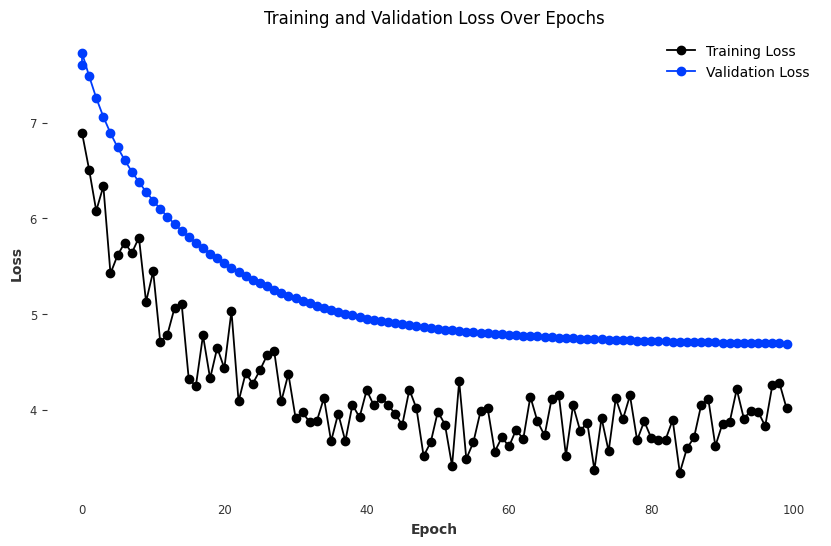

In [35]:
# Get the training history
history = metrics_logger.get_history()

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history["epoch"], history["train_loss"], label="Training Loss", marker="o")
plt.plot(history["epoch"], history["val_loss"], label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

In [36]:
current_model_path = "/content/drive/MyDrive/current_model_0222.pth"
model.save(current_model_path)

#  Predict

In [37]:
# at 50th percentile
input_chunk_length=80         # Input window length
output_chunk_length=40

forecasts = []

for seq_id, (series, dynamic_cov, future_cov) in enumerate(zip(test_series_scaled,
                                                    test_dynamic_covariates_scaled,
                                                    test_future_covariates )):
    # Define the starting index for the test set test_future_covariates combined_series_scaled, combined_dynamic_covariates_scaled
    #test_start_idx = train_size + val_size  # Combined train and validation sizes

    # Extract the target series for the test period
    # Include `input_chunk_length` of historical data for proper context
    series_for_forecast = series[:]

    # Extract the relevant portion of dynamic covariates
    dynamic_cov_for_forecast = dynamic_cov[:]

    # Extract the future covariates for the forecast horizon
    future_cov_for_forecast = future_cov[:]  # output_chunk_length

    # Generate the forecast
    forecast = model.predict(
        n=output_chunk_length,  # Forecast horizon
        series=series_for_forecast,  # Provide historical context + test series
        past_covariates=dynamic_cov_for_forecast,  # Align with historical context and test period
        future_covariates=future_cov_for_forecast  # Only use the forecast horizon
    )
    forecasts.append(forecast)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [38]:
# Inverse transformation for forecasts and test data
def inverse_transform_series_with_scalers(series_collection, scalers):
    """
    Applies inverse transformation to each scaled TimeSeries using its corresponding StandardScaler.

    Args:
        series_collection (list[TimeSeries]): List of scaled TimeSeries to invert.
        scalers (list[StandardScaler]): List of fitted scalers corresponding to each TimeSeries.

    Returns:
        list[TimeSeries]: List of TimeSeries with values reverted to their original scale.
    """
    original_series = []
    for ts, scaler in zip(series_collection, scalers):
        original_values = scaler.inverse_transform(ts.values())  # Invert scaling
        original_series.append(TimeSeries.from_times_and_values(ts.time_index, original_values))
    return original_series

# Inverse transformation examples
forecasts_original = inverse_transform_series_with_scalers(forecasts, target_scalers)
test_series_original = inverse_transform_series_with_scalers(test_series_scaled, target_scalers)

In [39]:
len(forecasts_original), forecasts_original[0].shape

(36, (40, 1, 1))

In [40]:
print(forecasts_original[0].time_index[0],forecasts_original[0].time_index[-1])
print('no. of train records:',len(forecasts_original[0]))

2024-10-07 00:00:00 2024-11-29 00:00:00
no. of train records: 40


In [41]:
len(test_series_original), test_series_original[0].shape

(36, (395, 1, 1))

In [42]:
print(test_series_original[0].time_index[0],test_series_original[0].time_index[-1])
print('no. of test records:',len(test_series_original[0]))

2023-04-03 00:00:00 2024-10-04 00:00:00
no. of test records: 395


# new final eval

In [43]:
# Custom MAPE function
def mape_numpy(y_true, y_pred):
    """
    Calculate Mean Absolute Percentage Error (MAPE).
    :param y_true: Ground truth values (actual).
    :param y_pred: Predicted values (forecast).
    :return: MAPE as a percentage.
    """
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Custom RMSE function
def rmse_numpy(y_true, y_pred):
    """
    Calculate Root Mean Squared Error (RMSE).
    :param y_true: Ground truth values (actual).
    :param y_pred: Predicted values (forecast).
    :return: RMSE value.
    """
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def mae_numpy(actual, predicted):
    return np.mean(np.abs(actual - predicted))

In [44]:
def cal_eval_tables():
    open_collection = []

    for k, v in recon_mapper.items():
        # 1) Flatten forecast & test data to 1D arrays
        forecasts_1d = forecasts_original[k].values().reshape(-1)
        test_series_1d = test_series_original[k][:40].values().reshape(-1)

        # 2) Compute metrics
        mape_value = mape_numpy(test_series_1d, forecasts_1d)
        rmse_value = rmse_numpy(test_series_1d, forecasts_1d)
        mae_value  = mae_numpy(test_series_1d, forecasts_1d)  # Add MAE

        # Compute cumulative return
        cumulative_return_0 = np.prod(1+forecasts_1d)
        price_minus_0 = stock_data_[(stock_data_['ticker_id_2']==v)&\
        (stock_data_['date']==val_series[k].time_index[-1])].head(1)['close'].values[0]
        return_price_0 = price_minus_0 * (cumulative_return_0)

        one_day_fwd = 1 + forecasts_1d[0]
        one_day_fwd_price = price_minus_0 * (one_day_fwd)

        # 3) Collect results in a dictionary
        open_dict = {
            'name': v,
            'mape': mape_value,
            'rmse': rmse_value,
            'mae': mae_value,
            'real_price':price_minus_0,
            'actual_date': val_series[k].time_index[-1],
            'cum_return' : cumulative_return_0,
            'return_price': return_price_0,
            'one_day_fwd_return': one_day_fwd,
            'one_day_fwd_price':one_day_fwd_price
        }
        open_collection.append(open_dict)

    # 4) Return as a DataFrame
    return (pd.DataFrame(open_collection))

In [45]:
view_1 = cal_eval_tables()
view_1

,name,mape,rmse,mae,real_price,actual_date,cum_return,return_price,one_day_fwd_return,one_day_fwd_price
0,BSX,518.0822,0.0162,0.0128,50.0300,2023-03-31,1.0691,53.4870,1.0003,50.0473
1,COP,214.6811,0.0305,0.0224,94.0763,2023-03-31,0.8152,76.6932,0.9949,93.5918
2,GS,195.5682,0.0166,0.0130,311.7788,2023-03-31,0.9695,302.2705,0.9998,311.7070
3,AMZN,442.1112,0.0279,0.0212,103.2900,2023-03-31,0.9370,96.7857,1.0206,105.4194
4,IBM,524.3164,0.0144,0.0118,121.2033,2023-03-31,1.0695,129.6223,1.0023,121.4761
5,TSLA,316.9651,0.0430,0.0350,207.4600,2023-03-31,0.9444,195.9336,1.0001,207.4760
6,AZO,292.9497,0.0194,0.0138,"2,458.1499",2023-03-31,1.1073,"2,721.8452",1.0082,"2,478.3225"
7,BAC,452.1154,0.0251,0.0209,27.2235,2023-03-31,1.2199,33.2087,1.0043,27.3409
8,UNH,382.6489,0.0210,0.0153,460.0362,2023-03-31,1.1359,522.5457,1.0034,461.5914
9,HCA,823.5947,0.0247,0.0197,259.8926,2023-03-31,1.2101,314.5089,1.0153,263.8612


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

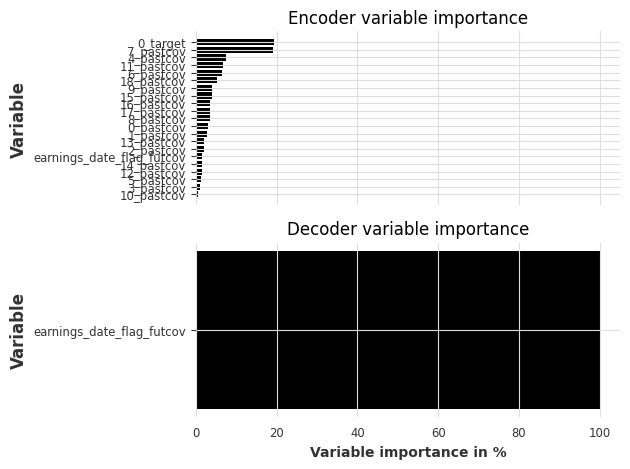

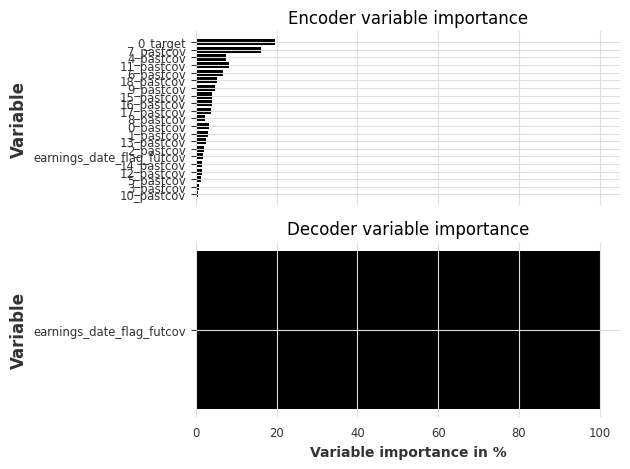

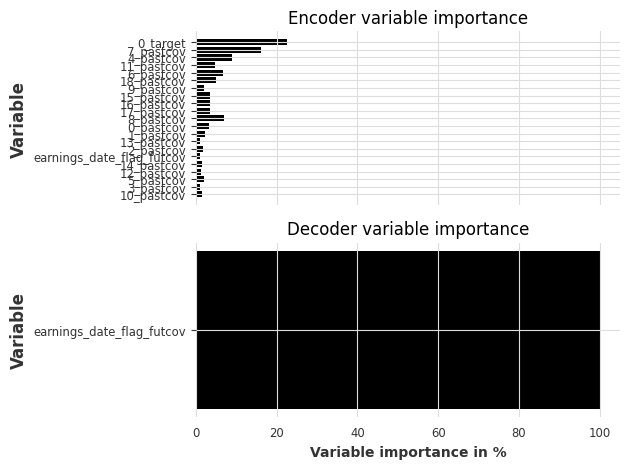

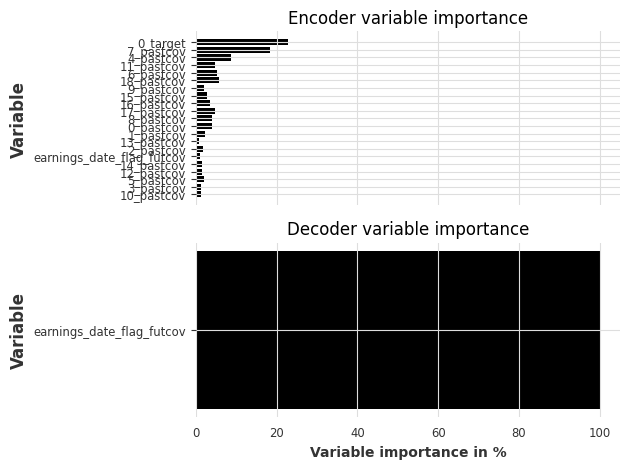

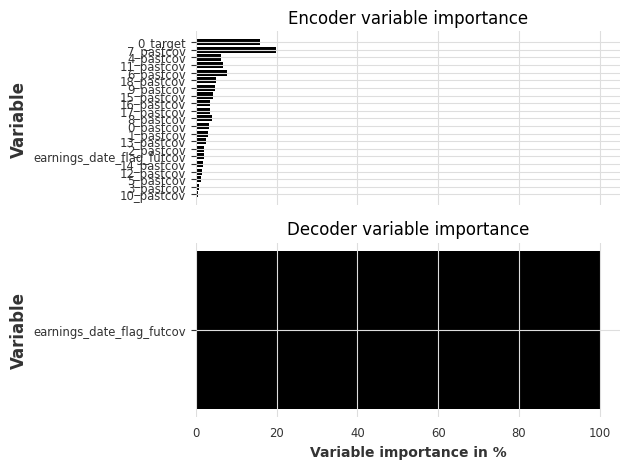

<Figure size 10000x5000 with 0 Axes>

In [47]:
from darts.explainability import TFTExplainer

# Initialize the explainer using scaled training data
explainer = TFTExplainer(
    model=model,
    background_series=train_series_scaled,  # Scaled target series
    background_past_covariates=train_dynamic_covariates_scaled,  # Scaled past covariates
    background_future_covariates=train_future_covariates,  # Scaled future covariates
)

# Generate explainability results
explainability_result = explainer.explain()
# Increase plot size
  # Width x Height in inches
# Plot variable importance
explainer.plot_variable_selection(explainability_result)

plt.figure(figsize=(100,50));

In [51]:
e1 = explainability_result.get_feature_importances()['encoder_importance']
e1_df = pd.concat(e1)
e1_df

,10_pastcov,3_pastcov,5_pastcov,12_pastcov,14_pastcov,earnings_date_flag_futcov,2_pastcov,13_pastcov,1_pastcov,0_pastcov,8_pastcov,17_pastcov,16_pastcov,15_pastcov,9_pastcov,18_pastcov,6_pastcov,11_pastcov,4_pastcov,7_pastcov,0_target
0,0.6000,0.9000,1.2000,1.4000,1.4000,1.6000,1.9000,2.0000,2.8000,3.1000,3.4000,3.5000,3.6000,4.0000,4.0000,5.2000,6.5000,6.8000,7.5000,19.2000,19.4000
1,0.6000,0.8000,1.2000,1.5000,1.6000,1.7000,2.0000,2.6000,2.9000,3.3000,2.2000,3.7000,4.0000,3.9000,4.7000,5.2000,6.8000,8.2000,7.5000,16.1000,19.5000
2,1.4000,1.1000,1.9000,1.3000,1.5000,0.9000,1.8000,0.9000,2.3000,3.3000,6.9000,3.6000,3.4000,3.5000,1.9000,5.0000,6.8000,4.7000,9.0000,16.1000,22.5000
3,1.2000,1.2000,2.0000,1.4000,1.6000,0.9000,1.8000,0.8000,2.3000,4.0000,4.1000,4.7000,3.6000,2.8000,2.1000,5.6000,5.2000,4.8000,8.8000,18.3000,22.7000
4,0.5000,0.8000,1.2000,1.5000,1.8000,1.9000,2.0000,2.6000,3.0000,3.2000,4.0000,3.6000,3.6000,4.3000,4.8000,5.0000,7.6000,6.8000,6.2000,19.8000,15.8000
5,0.7000,0.9000,1.3000,1.4000,1.5000,1.6000,1.9000,1.9000,2.6000,3.6000,2.2000,4.2000,3.5000,3.0000,4.6000,5.4000,5.0000,5.6000,7.6000,22.1000,19.4000
6,0.8000,0.9000,1.5000,1.4000,1.5000,1.3000,1.8000,1.3000,2.6000,3.7000,2.4000,4.1000,3.9000,3.5000,3.6000,5.8000,5.0000,6.1000,8.8000,16.5000,23.4000
7,1.0000,1.0000,1.7000,1.4000,1.4000,1.2000,1.8000,1.1000,2.4000,3.3000,6.6000,3.9000,3.5000,3.4000,3.3000,5.0000,5.8000,4.7000,7.8000,19.1000,20.7000
8,0.8000,0.9000,1.5000,1.4000,1.5000,1.3000,1.8000,1.4000,2.4000,3.3000,4.6000,3.7000,3.2000,3.6000,3.1000,4.9000,7.2000,4.7000,7.5000,22.1000,19.1000
9,1.0000,1.0000,1.6000,1.4000,1.5000,1.1000,1.8000,1.0000,2.3000,3.9000,4.1000,4.4000,3.5000,3.3000,2.7000,5.3000,4.6000,4.9000,8.2000,20.7000,21.6000


In [53]:
df_list = [pd.DataFrame(each_enc) for each_enc in e1]

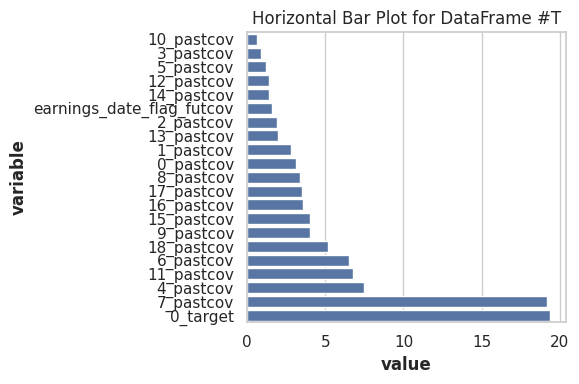

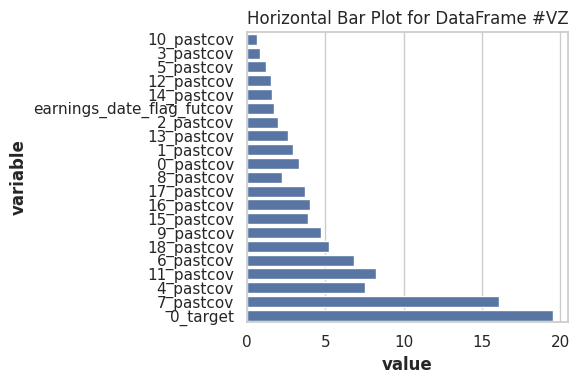

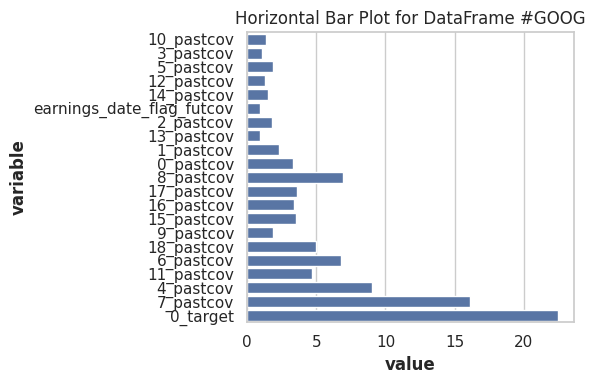

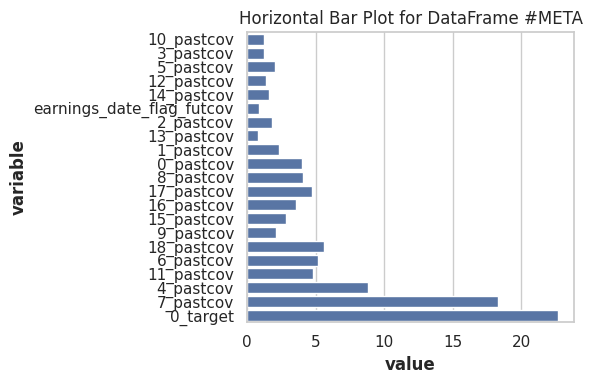

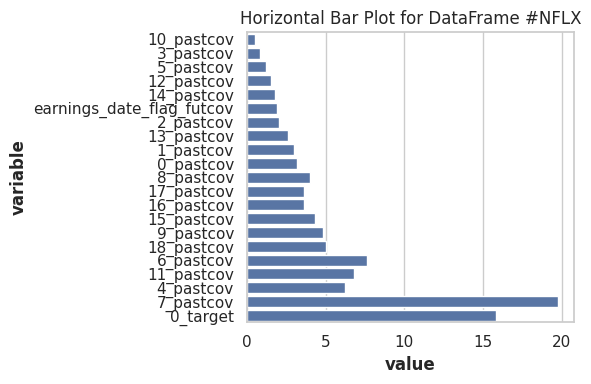

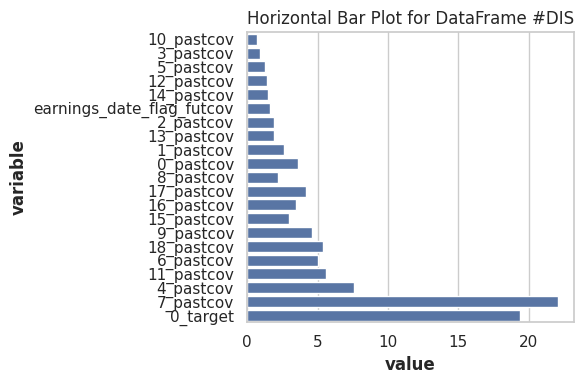

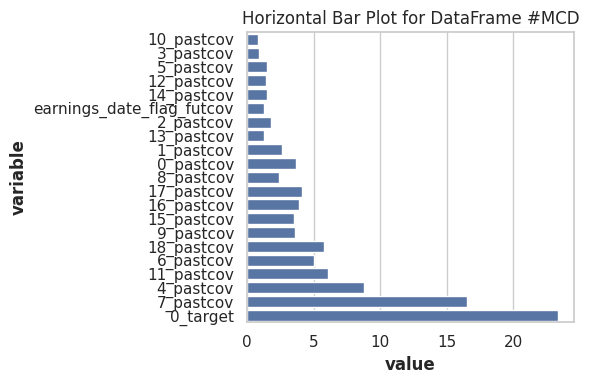

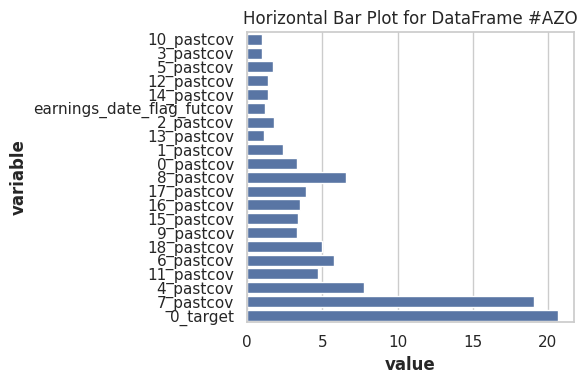

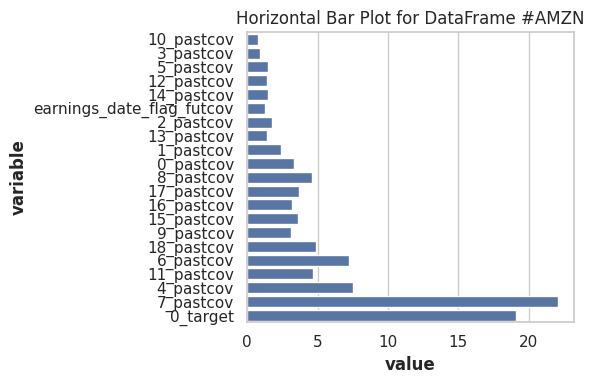

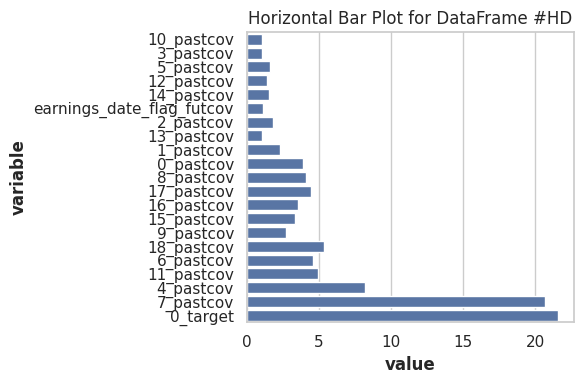

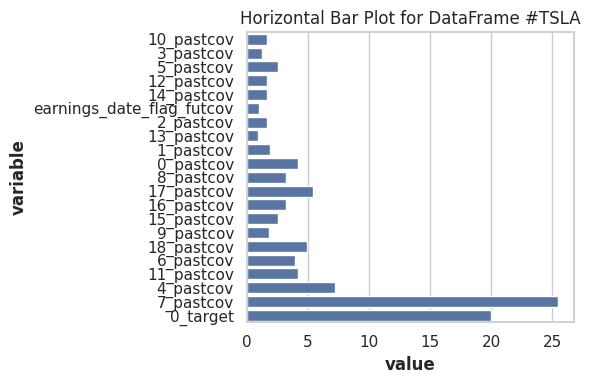

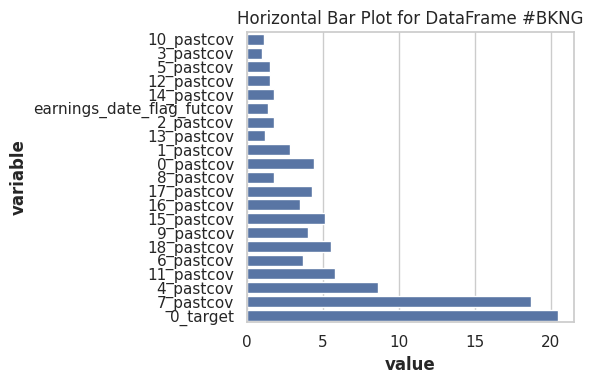

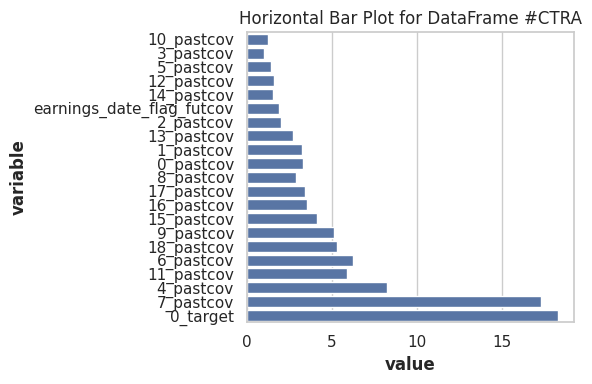

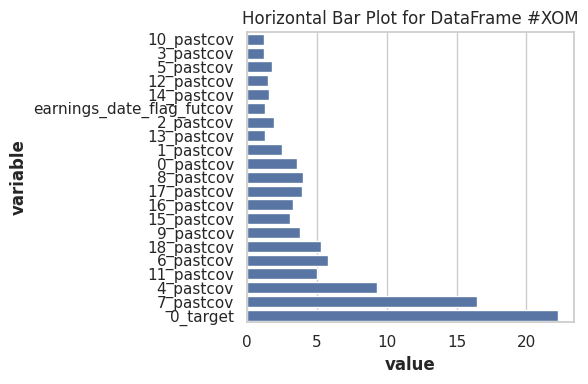

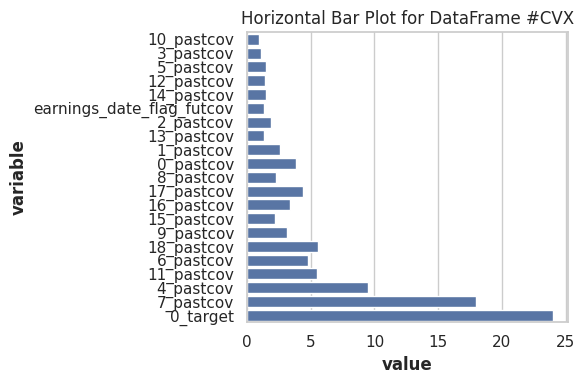

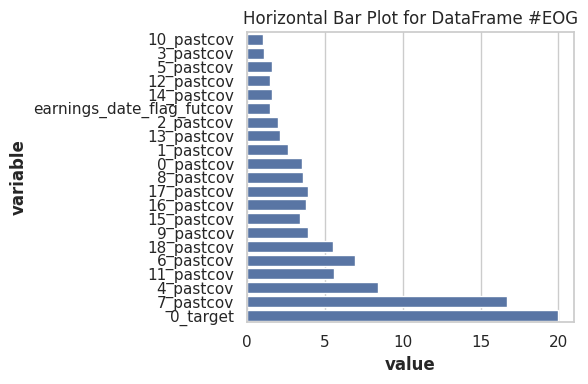

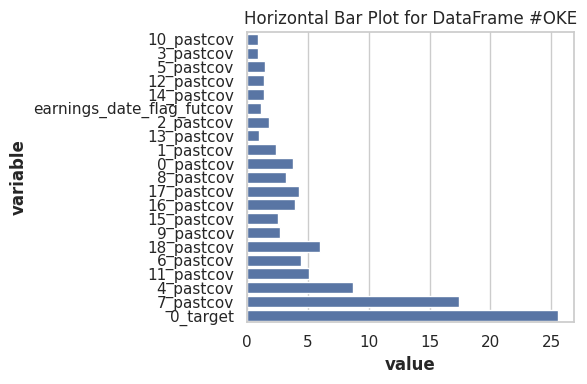

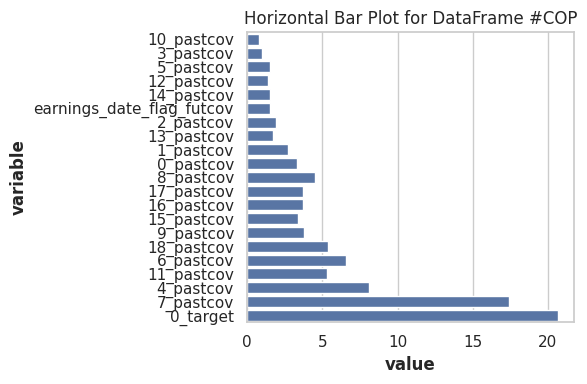

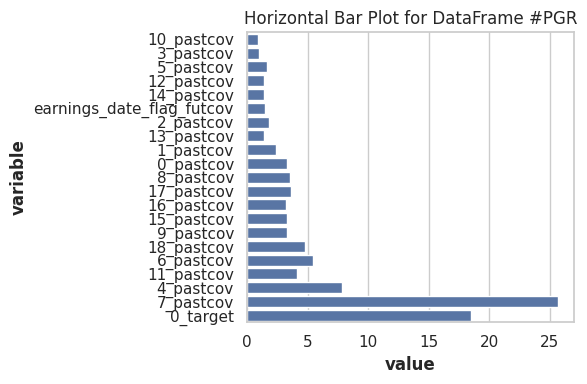

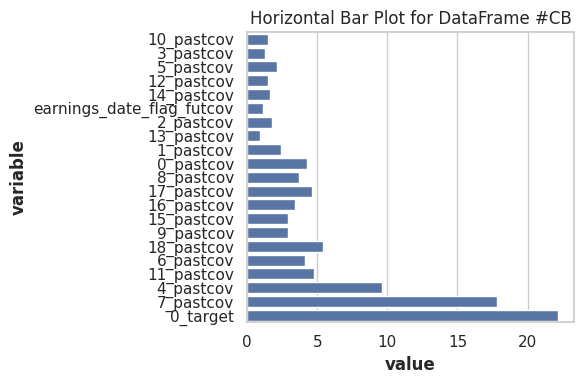

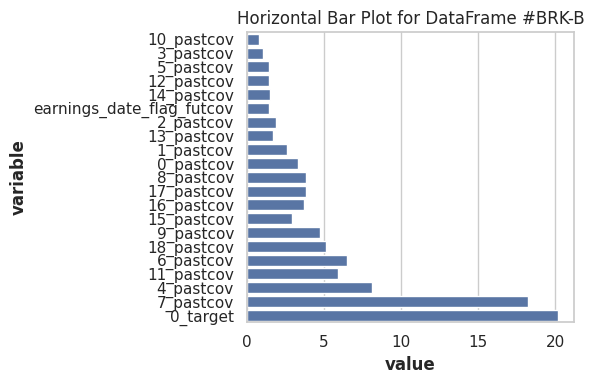

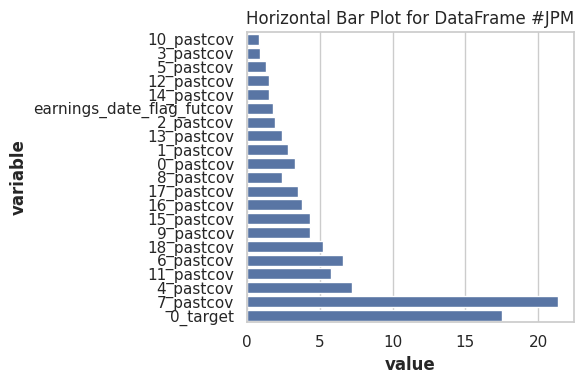

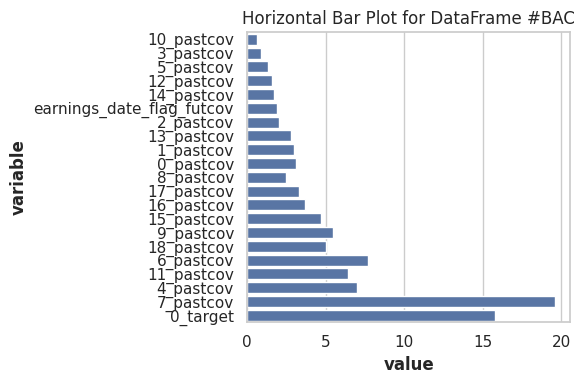

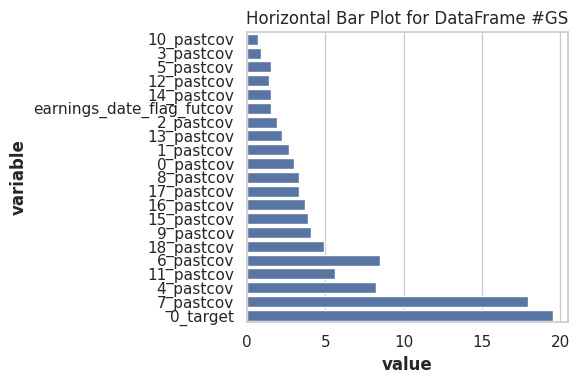

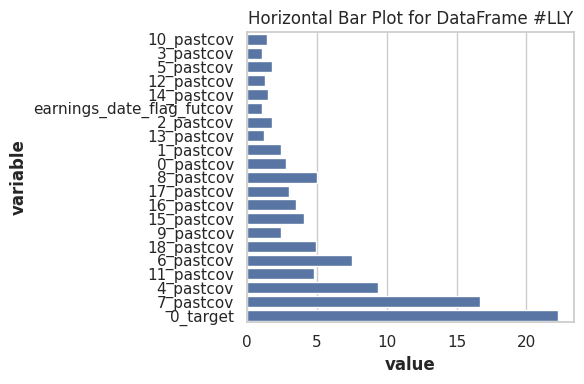

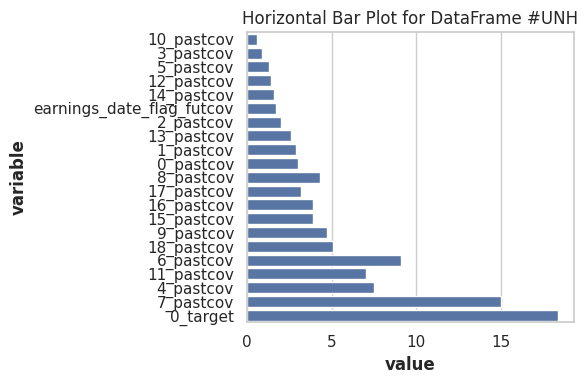

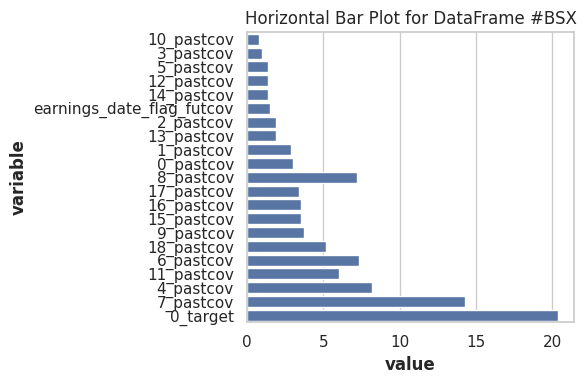

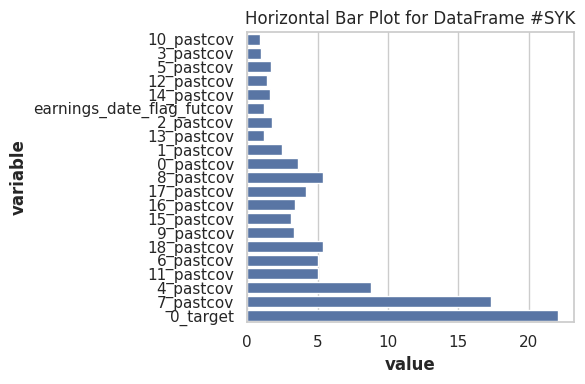

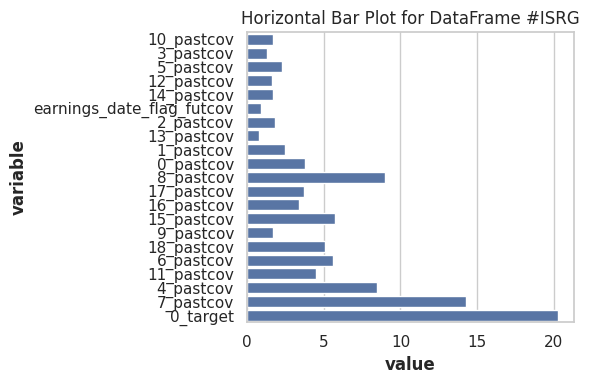

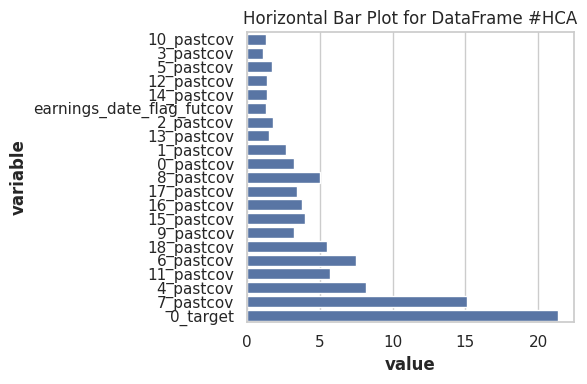

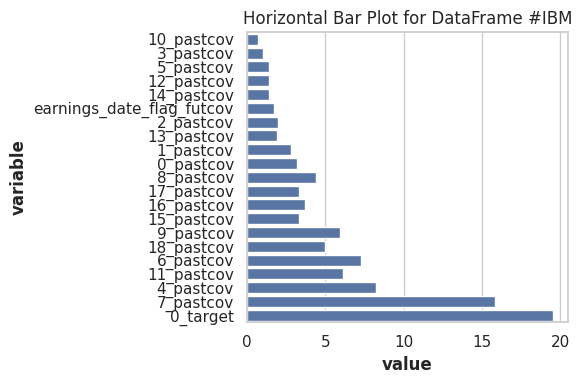

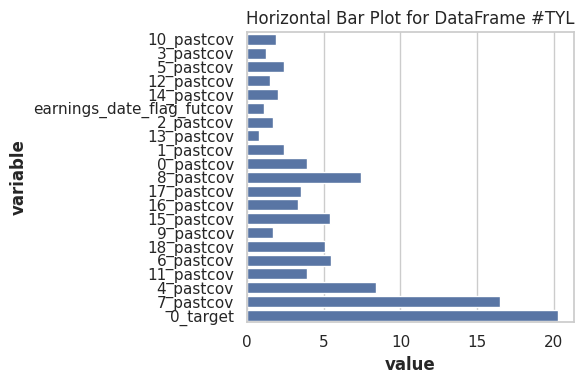

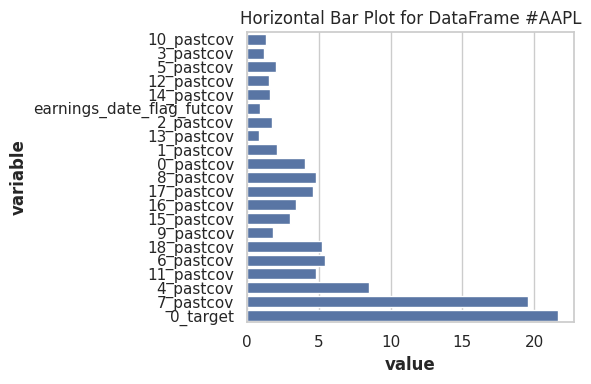

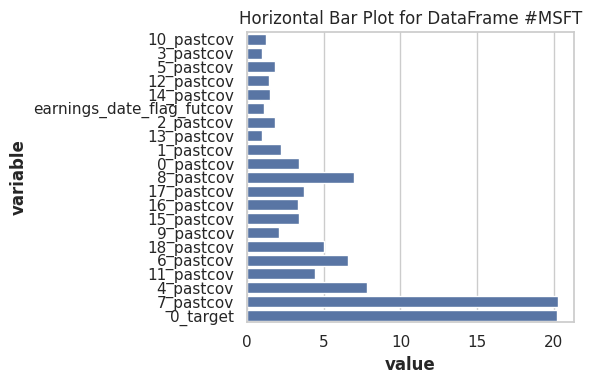

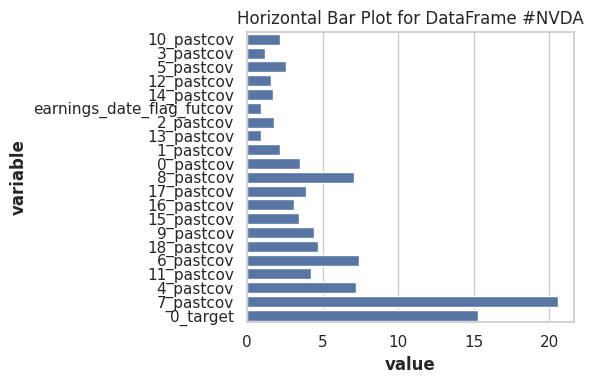

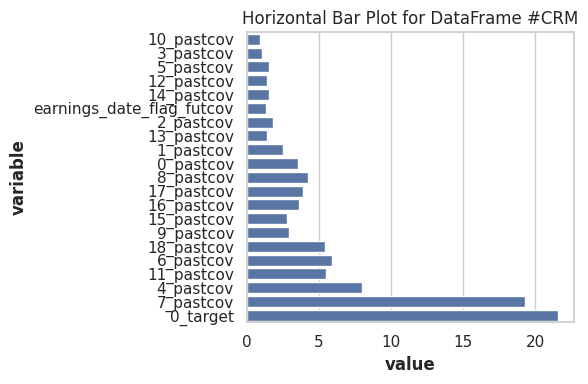

In [54]:
# 1. Set a Seaborn theme/palette
sns.set_theme(style="whitegrid", palette="deep")

# Loop over each single-row DataFrame
for i, single_row_df in enumerate(df_list):

    # Extract the single row as a Series
    row_series = single_row_df.iloc[0]

    # Convert Series to a new DataFrame with columns = [variable, value]
    plot_df = row_series.reset_index()
    plot_df.columns = ["variable", "value"]

    # Sort by value if you want descending bars (optional)
    # plot_df = plot_df.sort_values("value", ascending=False)

    # Create a new figure for each DataFrame
    plt.figure(figsize=(6, 4))
    sns.barplot(data=plot_df, y="variable", x="value", orient="h")
    plt.title(f"Horizontal Bar Plot for DataFrame #{recon_mapper[i]}")
    plt.tight_layout()  # Adjusts spacing to avoid cutoff labels
    plt.show()

# = = =